# Machine Learning Foundation

## Course 3, Part a: Logistic Regression LAB


## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) database, which was built from the recordings of study participants who carried a smartphone with an embedded inertial sensor while performing activities of daily living (ADL). The objective is to classify the activities the participants performed into one of the six following categories: walking, walking upstairs, walking downstairs, sitting, standing, and laying.

The following information is provided for each record in the dataset:

*   Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration
*   Triaxial Angular velocity from the gyroscope
*   A 561-feature vector with time and frequency domain variables
*   The activity label

More information about the features are available on the website linked above.


In [123]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [124]:
import seaborn as sns, pandas as pd, numpy as np

In [125]:
# Display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

## Question 1

Import the data and do the following:

*   Examine the data types--there are many columns, so it might be wise to use value counts.
*   Determine if the floating point values need to be scaled.
*   Determine the breakdown of each activity.
*   Encode the activity label as an integer.


In [126]:
### BEGIN SOLUTION
#data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')
data = pd.read_csv("data/Human_Activity_Recognition_Using_Smartphones_Data.csv")

In [127]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

The data columns are all floats except for the activity label.


In [128]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [129]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).


In [130]:
# The min for every single feature column is -1
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [131]:
# The max for every single feature column is 1
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities; they are relatively balanced.


In [132]:
# Target column: always do value_counts
# to see how balanced the classes are.
# They are quite balanced.
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.\
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.


In [133]:
# Classification problems require passing label-encoded target values,
# one-hot encoded (sparse) values are not accepted.
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)
### END SOLUTION

3069    2
7946    4
738     1
3479    1
2819    3
Name: Activity, dtype: int64

## Question 2

*   Calculate the correlations between the dependent variables.
*   Create a histogram of the correlation values.
*   Identify those that are most correlated (either positively or negatively).


In [134]:
# Calculate the correlation values between the feature values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()


In [135]:
### BEGIN SOLUTION
# Calculate the correlation values between the feature values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal.
# tril_indices_from returns a tuple of 2 arrays:
# the arrays contain the indices of the diagonal + lower triangle of the matrix:
# ([0,1,...],[0,0,...])
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
# NaN values are automatically dropped below with stack()
# zip creates a list of tuples from a tuple of arrays
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack() # multi-index stacking of a matrix: [m1:(m11, m12,...), m2:(m21, m22,...), ...]
               .to_frame() # convert in dataframe
               .reset_index() # new index
               .rename(columns={'level_0':'feature1', # new column names
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

In [136]:
# We have many correlation values, because we have 550+ features!
corr_values.shape # (157080, 4)

(157080, 4)

A histogram of the absolute value correlations.


In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

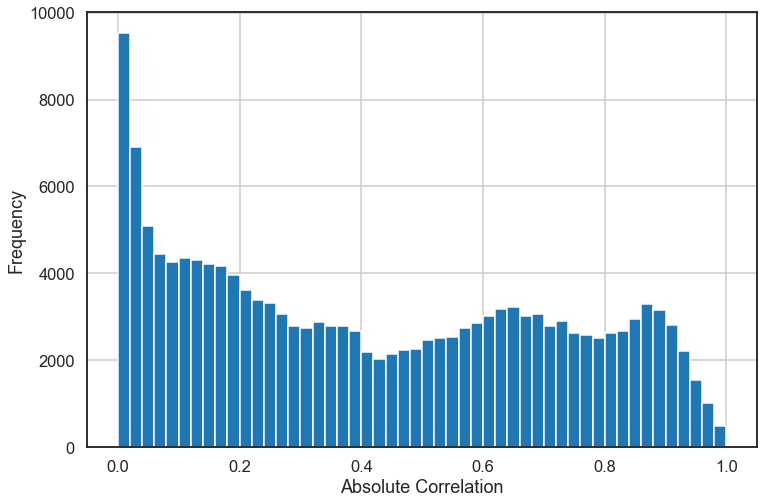

In [138]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [139]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')
### END SOLUTION

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

*   Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
*   Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.


In [140]:
# Orginal class ratios
data.Activity.value_counts(normalize=True)

0    0.188756
2    0.185067
1    0.172541
3    0.167201
5    0.149917
4    0.136518
Name: Activity, dtype: float64

In [141]:
### BEGIN SOLUTION
# StratifiedShuffleSplit allows to split the dataset
# into the desired numbers of train-test subsets
# while still maintaining the ratio of the predicted classes in the original/complete dataset
from sklearn.model_selection import StratifiedShuffleSplit

# Instantiate the StratifiedShuffleSplit object with its parameters
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, # 1 split: 1 train-test
                                          test_size=0.3, 
                                          random_state=42)

# Get the split indexes
train_idx, test_idx = next(strat_shuf_split.split(X=data[feature_cols], y=data.Activity))

# Create the dataframes using the obtained split indices
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [142]:
# Always check that the ratios are OK
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [143]:
y_test.value_counts(normalize=True)
### END SOLUTION

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

*   Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
*   Using cross validation to determine the hyperparameters and fit models using L1 and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.


In [144]:
### BEGIN SOLUTION
# Logistic regression is originally a binary classification tool
# but the sklearn implementation handles multiple classes.
# Depending on the solver, different approaches are taken.
# The liblinear solver uses the one-vs-rest approach; so the model is fit N times,
# being N the number of classses we have.
# liblinear works nice for smaller datasets, read the documentation for more.
# Note: we can add regularization to the LogisticRegression objects in the parameters:
# penalty: l1, l2
# C: 1/lambda -> the larger the less regularization strength
# Also, we can use the cross-validation version to detect the optimum C value
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [145]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression: it takes a while
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [146]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)
### END SOLUTION

## Question 5

*   Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.


In [147]:
# Since we have a multi-class classification model with 6 classes and 561 features
# we get 6 x 561 coefficients.
# Each class-feature coefficient is the strength of the effect that feature
# has on the log odds ratio of the class
lr.coef_.shape

(6, 561)

In [148]:
### BEGIN SOLUTION
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_ # 6 x 561
    # Create multi-index columns:
    #          lr          l1          l2
    # 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

# Create dataframe from list of dataframes
coefficients = pd.concat(coefficients, axis=1)

# Show 10 random coefficient values
coefficients.sample(10)

lr                                                     l1  \
            0         1         2         3         4         5    0   
539 -0.030195 -0.260253  0.141758  0.318200 -0.558350 -0.185984  0.0   
122  0.091034 -0.757336  0.261228 -0.309310 -0.022101  0.233949  0.0   
245 -0.020129  0.084135 -0.158133 -0.348243  0.212745 -0.018933  0.0   
472 -0.011810  0.320884  0.031645  0.155750  0.179445 -0.141384  0.0   
248  0.121825  0.312781 -0.043150 -0.114497  0.631182 -0.205739  0.0   
419 -0.001539  0.197548  0.234874  0.237327  0.122819  0.064808  0.0   
108 -0.063205 -0.226215  0.360451  0.460656 -0.777113 -0.213172  0.0   
340  0.003508  0.211189  0.203123  0.202091  0.080833  0.068443  0.0   
332 -0.006886  0.188199  0.113870 -0.132579  0.100317 -0.192501  0.0   
304 -0.019934  0.146491  0.020694  0.017368  0.146713 -0.122915  0.0   

                                                             l2            \
            1         2         3         4         5         0         1   
539 -0.679640  0.416661  0.632936 -1.414651  0.000000 -0.159644 -2.573062   
122 -2.689903  0.000000  0.000000  0.000000  1.113810  0.177119 -3.594668   
245  0.000000  0.000000  0.000000  0.114757  0.000000 -0.039755  0.344177   
472  0.826960  0.000000  0.000000  0.063104  0.000000 -0.035828  1.168861   
248  0.000000  0.000000  0.000000  3.271464 -0.257545  0.240515  0.572101   
419  0.025811  0.179295  0.000000  0.173709  0.153592 -0.023849  0.475945   
108 -0.507894  0.000000  0.696017 -4.279355 -0.323167 -0.127321 -1.635698   
340  0.000000  0.081096  0.000000  0.039971  0.036316 -0.015037  0.487674   
332  0.000000  0.000000  0.000000  0.059136  0.000000 -0.032630  0.689068   
304  0.000000  0.000000  0.000000  0.424095 -0.306156 -0.054011  0.487346   

                                             
            2         3         4         5  
539  0.610743  0.810410 -2.624205  0.261025  
122  0.451301 -0.917271 -0.081811  1.961899  
245 -0.290339 -0.753941  1.053522 -0.343150  
472  0.000624  0.497215  0.475272 -0.959961  
248  0.023893  0.041511  3.103836 -1.250451  
419  0.292924  0.700171  0.453900  0.396372  
108  0.501550  1.294241 -3.018316 -1.043507  
340  0.228587  0.563130  0.249498  0.405817  
332  0.126704 -0.226612  0.133748 -1.294600  
304  0.028985  0.263078  0.836568 -0.756073

In [149]:
# All coefficients of all the models:
# 561 features x (3 models * 6 classes)
coefficients.shape

(561, 18)

Prepare six separate plots for each of the multi-class coefficients.


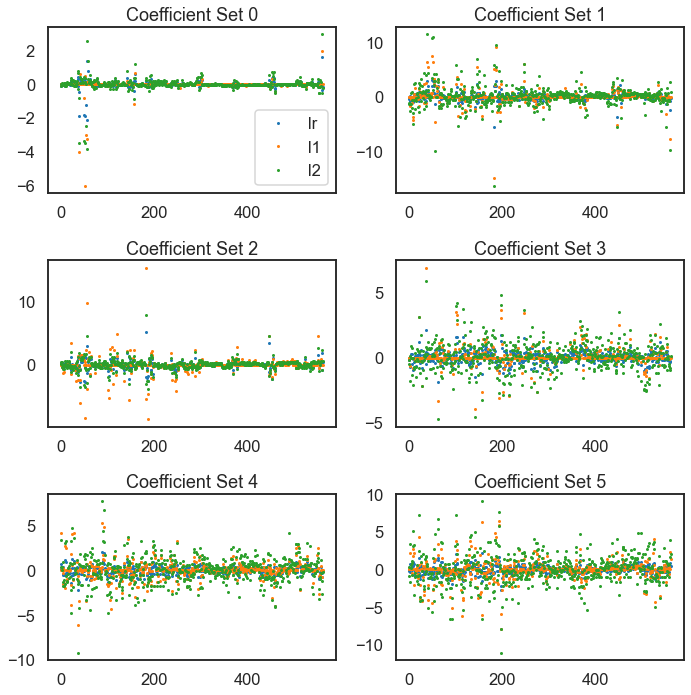

In [150]:
# All feature coefficients for each class are plotted
# differentiating the 3 models
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()
### END SOLUTION

## Question 6

*   Predict and store the class for each model.
*   Store the probability for the predicted class for each model.


In [151]:
### BEGIN SOLUTION
# Predict the class and the probability for each model
# using the test split.
# The class and the probability are important: predict() and predict_proba()
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [152]:
y_prob.head()
### END SOLUTION

,lr,l1,l2
0,0.998939,0.998965,0.999757
1,0.988165,0.999485,0.999998
2,0.987592,0.995203,0.999930
3,0.981381,0.999173,0.994338
4,0.998277,0.999920,0.999997


In [153]:
# Which are the data-points that obtained a different class
# prediction dpeending on the model?
y_pred[y_pred.lr != y_pred.l1]

,lr,l1,l2
88,2,1,1
197,2,1,1
296,1,2,1
388,1,2,1
430,4,5,5
489,2,1,1
769,4,3,3
853,5,3,3
1036,1,2,1
1071,1,2,2


## Question 7

For each model, calculate the following error metrics:

*   Accuracy
*   Precision
*   Recall
*   F-score
*   Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.


In [154]:
### BEGIN SOLUTION
# For each model, we compute the most important metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list() # precision, recall, f1, accuracy, roc-auc
cm = dict() # confusion matrix

# We need to pass the results of each model separately
for lab in coeff_labels:

    # Precision, recall, f-score from the multi-class support function
    # Since we have multiple classes, there is one value for each class for
    # precision, recall, F1 and support.
    # The support is the number of occurrences of each class in ``y_true``.
    # However, we can compute the weighted average to get a global value with average='weighted'.
    # Then, support doesn't make sense.
    # Without the average parameter, we get arrays of six values for each metric,
    # one item in each array for each class.
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    # Accuracy is for the complete dataset (ie., all classes).
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    # label_binarize performs a one-hot encoding,
    # so from an integer class we get an array of one 1 and the rest 0s.
    # This is necessary for computing the ROC curve, since the target needs to be binary!
    # Again, to get a single ROC-AUC from the 6 classes, we pass average='weighted'
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [155]:
metrics
### END SOLUTION

,lr,l1,l2
precision,0.984144,0.983514,0.984148
recall,0.984142,0.983495,0.984142
fscore,0.984143,0.983492,0.984143
accuracy,0.984142,0.983495,0.984142
auc,0.990384,0.989949,0.990352


## Question 8

*   Display or plot the confusion matrix for each model.


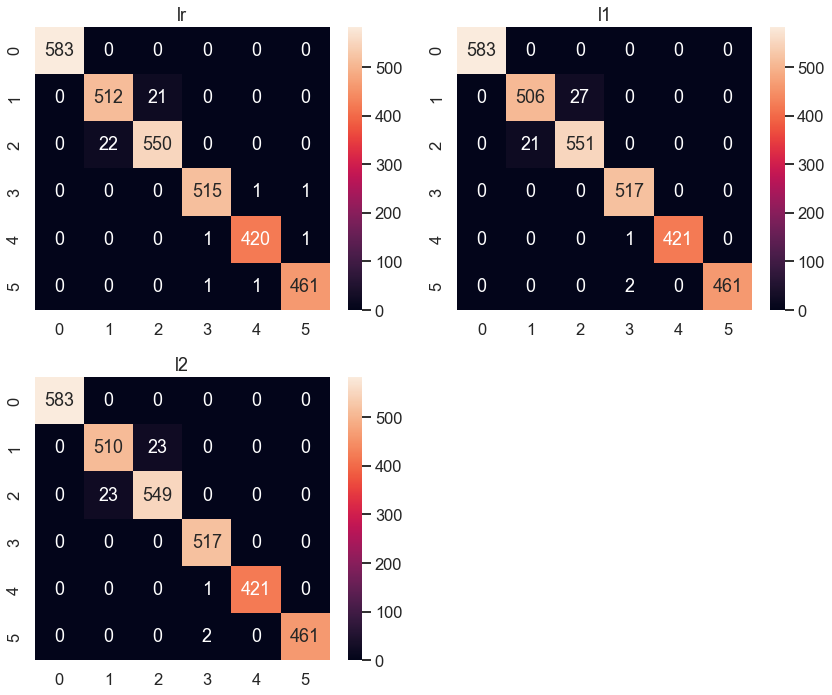

In [158]:
### BEGIN SOLUTION
# Confusion matrix plots: one for each model
# Actual vs. Predicted
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off') # we have 2x2 subplots, but want to show only the first 3 

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()
### END SOLUTION

In [161]:
# Always check the classes which are more often confused.
# Why are they similar? How could we differentiate them? Do we need more data?
# We see that the most confused classes are 1 & 2
# We can check their meaning with the label encoder
# 'SITTING', 'STANDING'
le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

***

### Machine Learning Foundation (C) 2020 IBM Corporation
